## Project : Predict students' dropout and academic success 


The input comes from https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success and is described as such:
 <br>
A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies. The dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. The data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes. <br>

The data seems to be already very clean so no additional data cleaning was done. <br>

All the code below as well as a copy of this notebook is present at https://github.com/SokratisStudent/csca-5622-final.
The original paper is https://link.springer.com/chapter/10.1007/978-3-030-72657-7_16/tables/3

In [1]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes)
feature_dataset = predict_students_dropout_and_academic_success.data.features
target_dataset = predict_students_dropout_and_academic_success.data.targets

There are 4423 students in the dataset with 36 features listed below:

In [2]:
feature_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

### Feature data view
No data cleaning required, using the columns as they are.

In [3]:
print(feature_dataset.columns)
print(feature_dataset.head)

Index(['Marital Status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

### Target data view
No data cleaning required, using the columns as they are. The labels for the 3 outcomes are as per the paper: <br>
<blockquote>Each record was classified as Success, Relative Success and Failure, depending on the time that the student took to obtain her degree. Success means that the student obtained the degree in due time; Relative Success means that the student took until three extra years to obtain the degree; Failure means that the student took more than three extra years to obtain the degree or doesn’t obtain the degree at all. This somehow corresponds to three levels of risk: ‘low-risk’ students with high probability of succeeding; ‘medium-risk’ students, for whom the measures taken by the institution might contribute to success; and the ‘high-risk’ students, who have a high probability of failing. </blockquote>

In [4]:
print(target_dataset)
print(target_dataset.dtypes)
target_dataset.groupby('Target').value_counts()

        Target
0      Dropout
1     Graduate
2      Dropout
3     Graduate
4     Graduate
...        ...
4419  Graduate
4420   Dropout
4421   Dropout
4422  Graduate
4423  Graduate

[4424 rows x 1 columns]
Target    object
dtype: object


Target
Dropout     1421
Enrolled     794
Graduate    2209
Name: count, dtype: int64

## Correlation Matrix
By including all the features then the 4 most correlated features are:
<ol>
<li>Number of curricular units approved in the 2nd semester</li>
<li>Grade average in the 2nd semester (between 0 and 20) </li>
<li>Number of curricular units approved in the 1st semester</li>
<li>Grade average in the 1st semester (between 0 and 20) </li>
</ol>

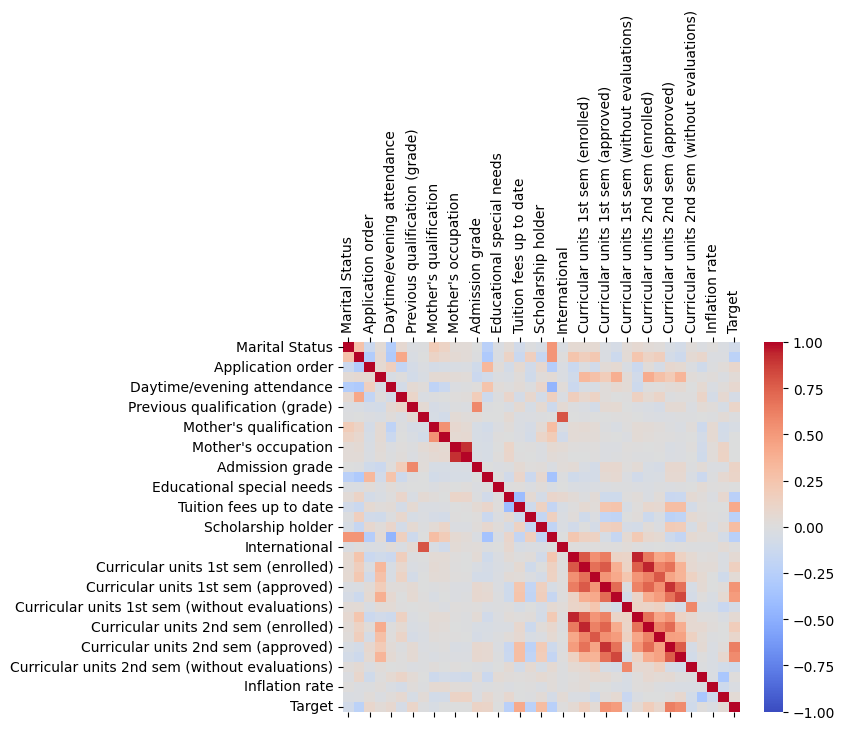

In [5]:
combined_dataset = feature_dataset.copy()
target = []
for target_value in target_dataset['Target']:
    if target_value == 'Graduate':
        target.append(2)
    elif target_value == 'Enrolled':
        target.append(1)
    elif target_value == 'Dropout':
        target.append(0)

combined_dataset['Target'] = target
cm = combined_dataset.corr()

#print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(data=cm, vmin=-1.0, vmax=1.0, center=0.0, cmap='coolwarm')
ax.tick_params(axis='x', labelrotation=90.0, top=True, labeltop=True, labelbottom=False)
plt.show()

I also wanted to check is on the features inherent to a person before joining college so this is the correlation matrix for the first 21 features. The strongest predictors seem to be 'Tuition fees up to date' and 'Scholarship holder' which both make sense as they both are motivation indicators.

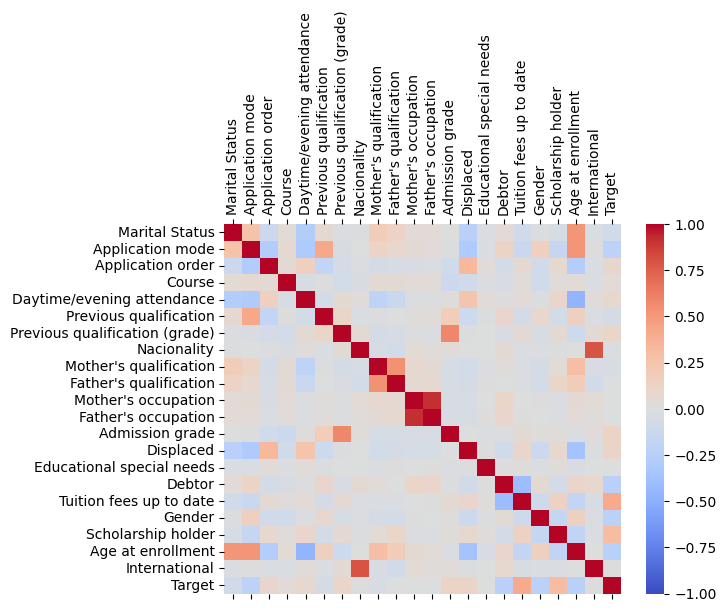

In [6]:
combined_dataset = feature_dataset.iloc[:, 0:21].copy()
target = []
for target_value in target_dataset['Target']:
    if target_value == 'Graduate':
        target.append(2)
    elif target_value == 'Enrolled':
        target.append(1)
    elif target_value == 'Dropout':
        target.append(0)

combined_dataset['Target'] = target
cm = combined_dataset.corr()

#print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(data=cm, vmin=-1.0, vmax=1.0, center=0.0, cmap='coolwarm')
ax.tick_params(axis='x', labelrotation=90.0, top=True, labeltop=True, labelbottom=False)
plt.show()

## Pair Plot
The pair plot for these features selected is not very helpful as a lot of the features are categorical.

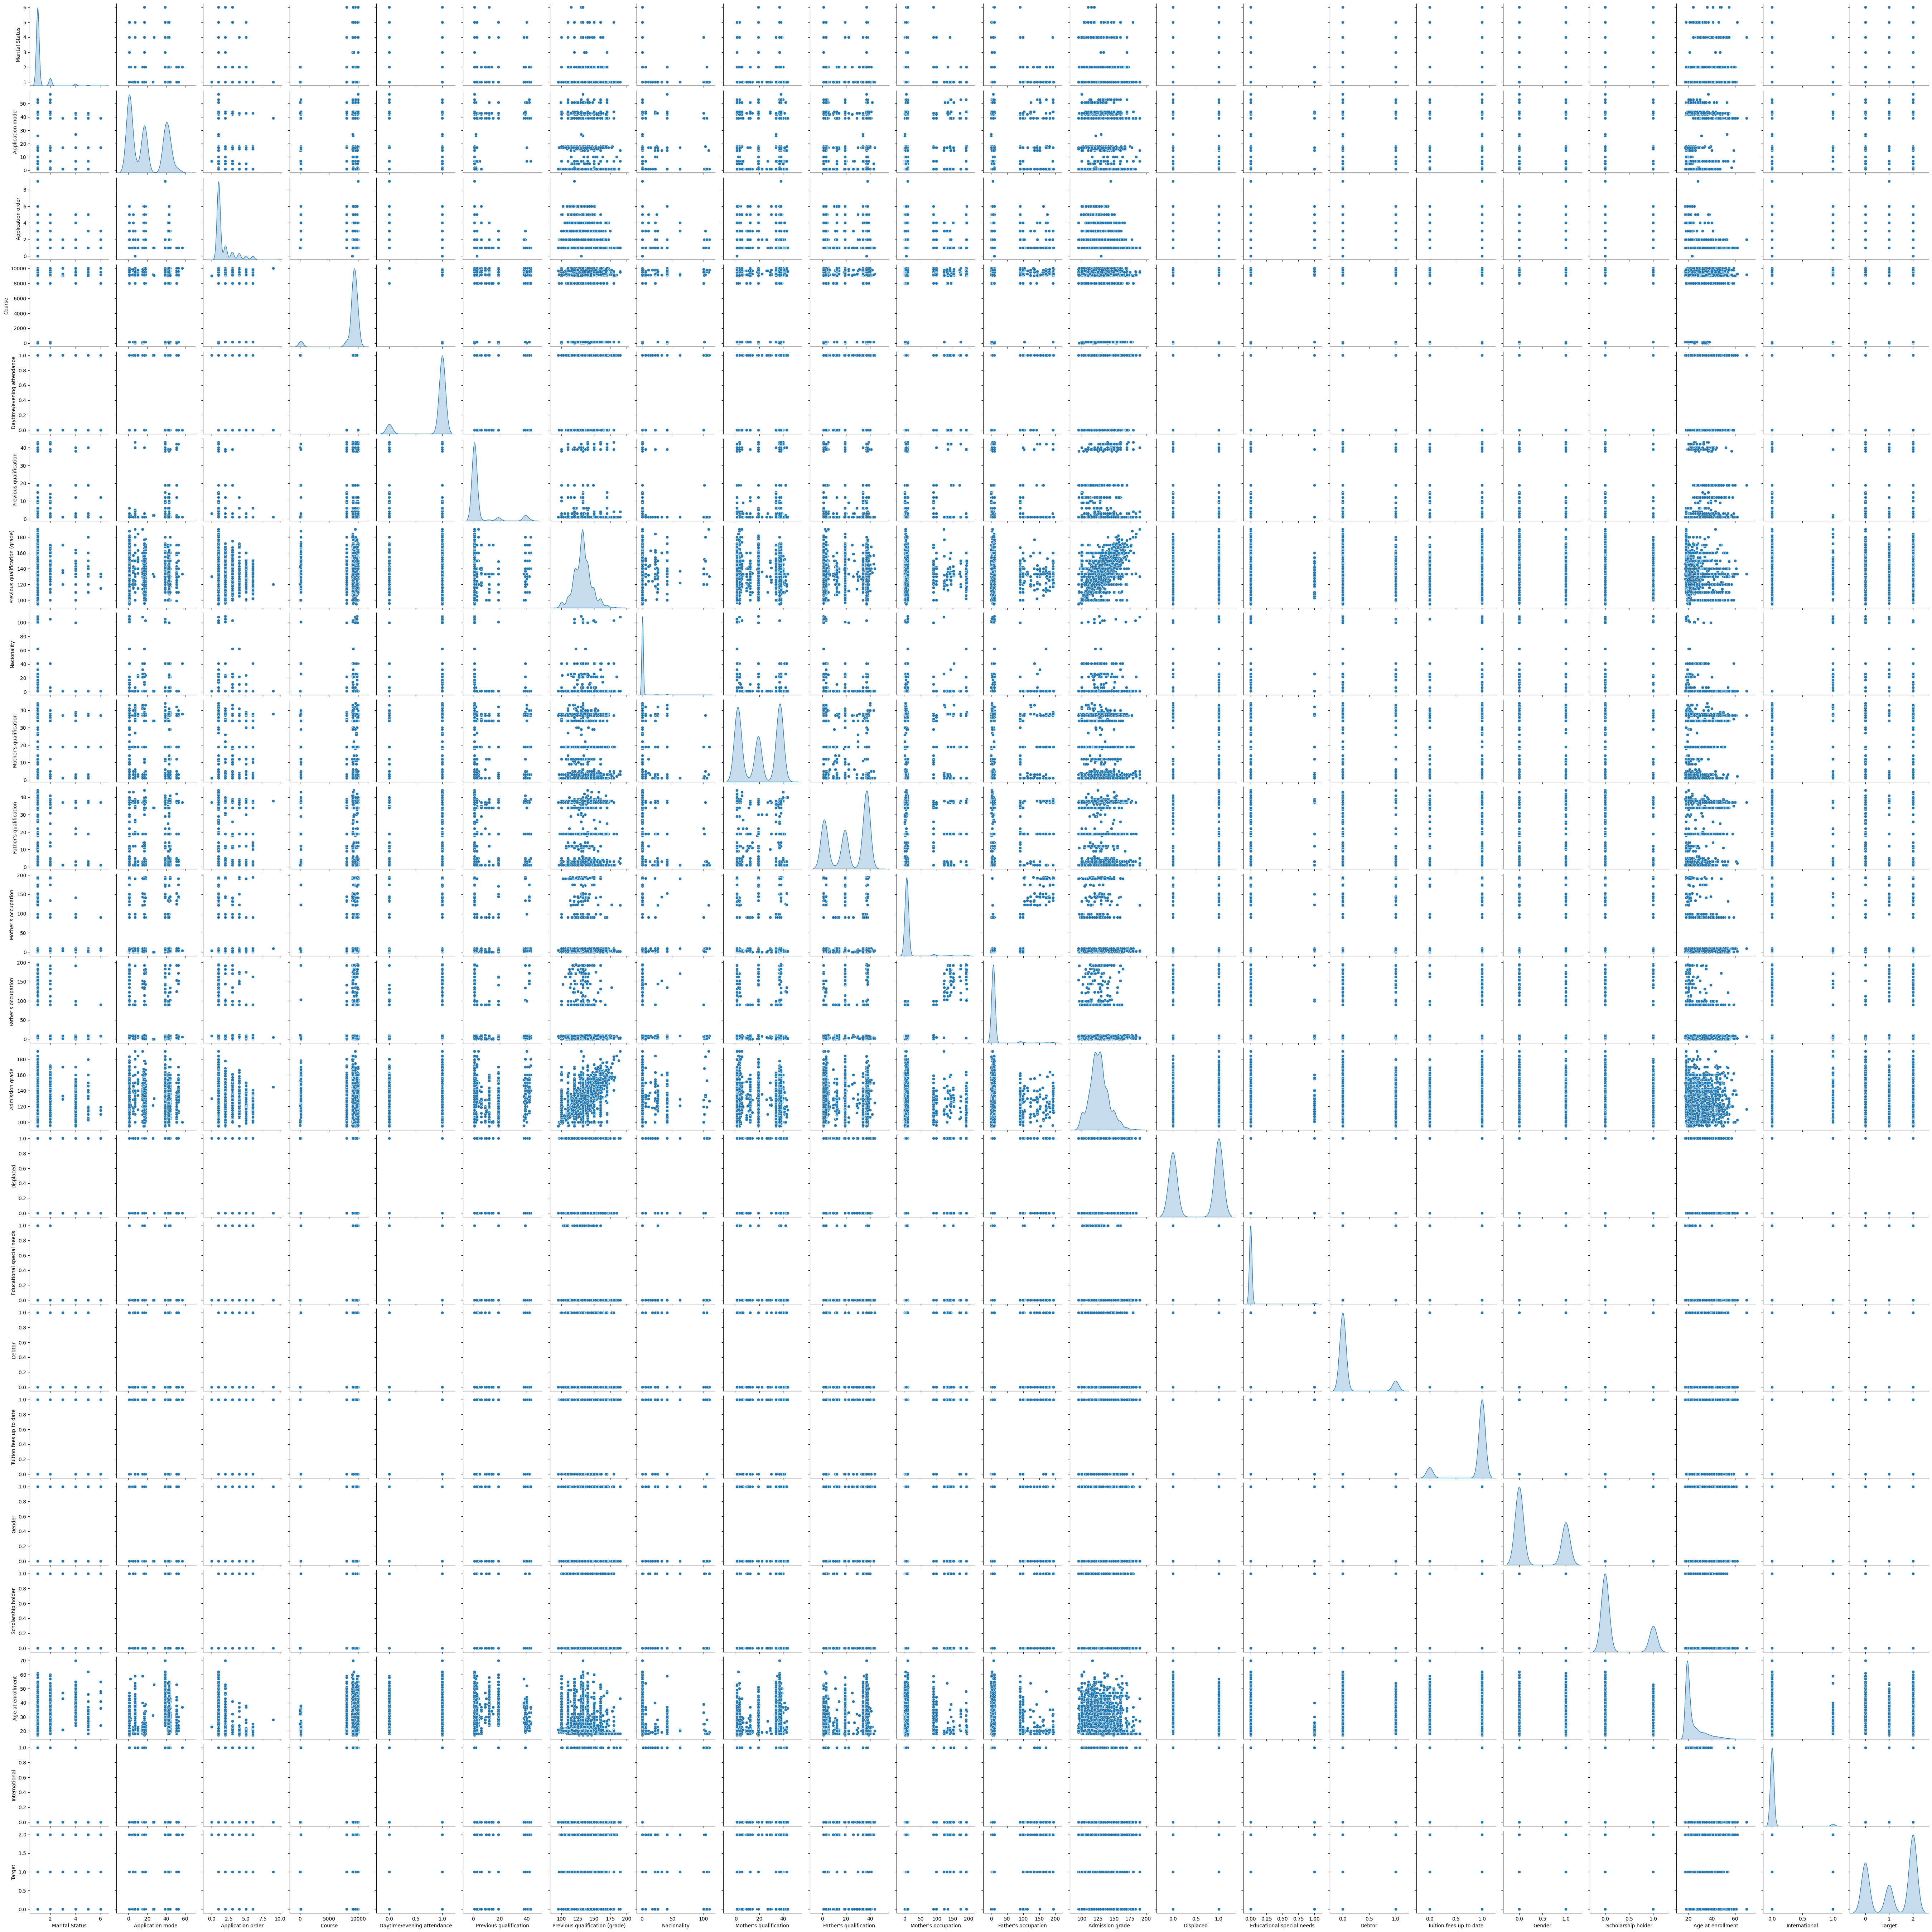

In [7]:
sns.pairplot(data=combined_dataset, kind='scatter', diag_kind='kde')
plt.show()

### Setting up our decision tree classifier
I decided to use all 36 features in the classification and use a decision tree classifier.
I split the data to be 80% training and 20% testing.
I created functions to evaluate sklean score as a single value to optimize and another to output precision/recall and other tree parameters.
Then just using the default values of sklearn, we get the baseline accuracy below

In [8]:
from pandas import DataFrame
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score

(train_features, test_features, train_targets, test_targets) = train_test_split(feature_dataset, target_dataset, test_size=0.2, random_state=80)


def build_dt(features, labels, max_depth=None, max_leaf_nodes=None, ccp_alpha=0.0):
    return DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, ccp_alpha=ccp_alpha).fit(features, labels)

def evaluate_score(clf, features, labels):
    return clf.score(features, labels)

def evaluate(dt, features, labels):
    y_pred = dt.predict(features)
    precision = precision_score(labels, y_pred, average='macro', zero_division=0.0)
    recall = recall_score(labels, y_pred, average='macro', zero_division=0.0)
    depth = dt.get_depth()
    l_nodes = dt.get_n_leaves()
    return (precision, recall, depth, l_nodes)

# Build the default tree and evaluate it as a baseline
dt = build_dt(train_features, train_targets)
(def_precision, def_recall, actual_depth, leaf_nodes) = evaluate(dt, test_features, test_targets)
def_score = evaluate_score(dt, test_features, test_targets)
print(f'Starting point - Decision Tree with {actual_depth=} and {leaf_nodes=} has precision={def_precision:f} and recall={def_recall:f} and {def_score=:f}')

Starting point - Decision Tree with actual_depth=23 and leaf_nodes=650 has precision=0.586853 and recall=0.586107 and def_score=0.663277


### Improving the best value for max_depth
After max_depth ~=5 the values do not improve moving to higher max_depth - the trees just become more and more over-fitted.

Max-depth tree - Decision Tree with actual_depth=5 and leaf_nodes=32 has precision=0.684433 and recall=0.629835 and best_score=0.750282


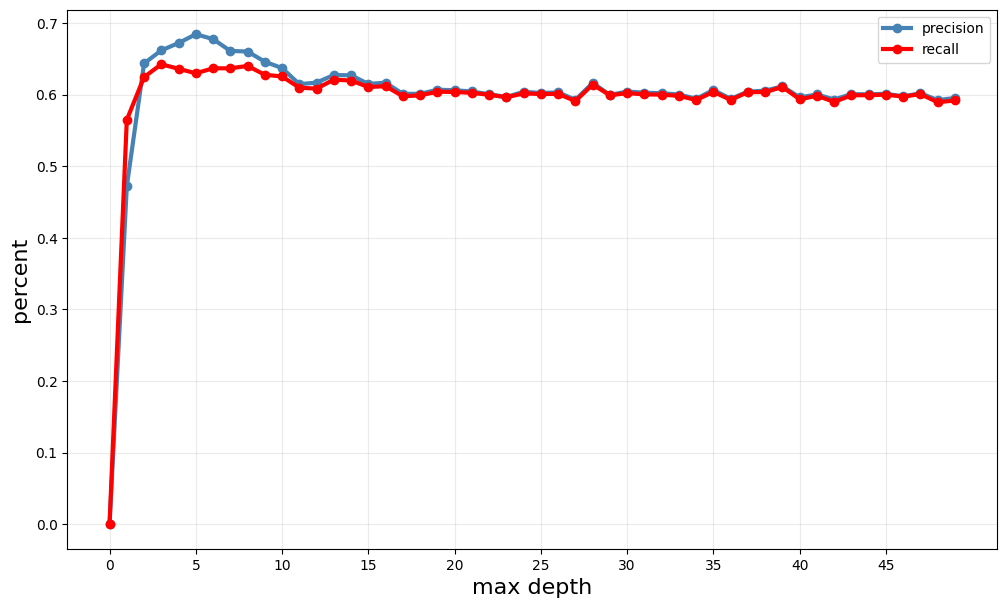

In [9]:
import numpy as np

precision_list = [ 0 ]
recall_list = [ 0 ]
current_best_precision = def_precision
current_best_recall = def_recall
current_best_score = def_score
current_best_max_depth = 0
max_max_depth=50

for depth in range(1, max_max_depth):
    dt = build_dt(train_features, train_targets, max_depth=depth)
    score = evaluate_score(dt, test_features, test_targets)
    if score > current_best_score:
        current_best_score = score
        current_best_max_depth = depth
    (precision, recall, actual_depth, leaf_nodes) = evaluate(dt, test_features, test_targets)
    precision_list.append(precision)
    recall_list.append(recall)

dt = build_dt(train_features, train_targets, max_depth=current_best_max_depth)
(current_best_precision, current_best_recall, actual_depth, leaf_nodes) = evaluate(dt, test_features, test_targets)
best_score = evaluate_score(dt, test_features, test_targets)
print(f'Max-depth tree - Decision Tree with {actual_depth=} and {leaf_nodes=} has precision={current_best_precision:f} and recall={current_best_recall:f} and {best_score=:f}')

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(np.arange(0, max_max_depth), precision_list, marker="o", color="steelblue", lw=3, label="precision")
ax.plot(np.arange(0, max_max_depth), recall_list, marker="o", color="red", lw=3, label="recall")
ax.legend()
ax.set_xlabel("max depth", fontsize=16)
ax.set_ylabel("percent", fontsize=16)
plt.xticks(range(0, max_max_depth, 5))
ax.grid(alpha=0.25)
plt.show()

### Figure out the best value for max_leaf_nodes
We let max_depth vary as needed to evaluate what effect max_leaf_nodes will have. The output is that the max_depth stays in the 5-6 range while the leaf-nodes needed are only 21 and it gives a slightly better result than letting the max_leaf_node value be unlimited.

Pre-pruning tree - Decision Tree with actual_depth=6 and leaf_nodes=21 has precision=0.704706 and recall=0.645985 and best_score=0.759322


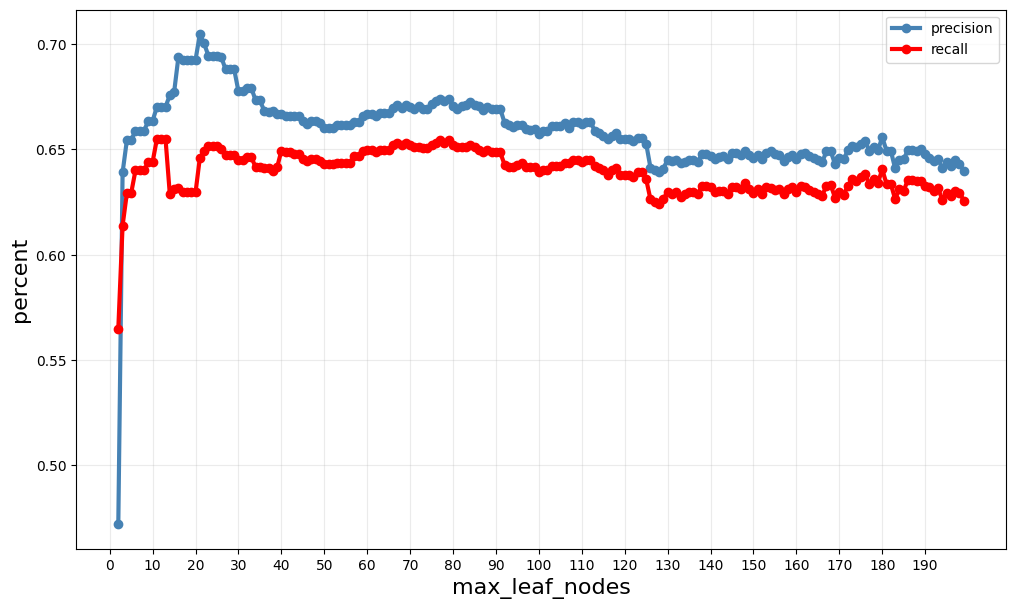

In [10]:
precision_list = []
recall_list = []
current_best_max_leaf_nodes = 0
max_max_leaf=200

for leaf in range(2, max_max_leaf):
    dt = build_dt(train_features, train_targets, max_leaf_nodes=leaf)
    score = evaluate_score(dt, test_features, test_targets)
    if score > current_best_score:
        current_best_score = score
        current_best_max_leaf_nodes = leaf
    (precision, recall, actual_depth, leaf_nodes) = evaluate(dt, test_features, test_targets)
    precision_list.append(precision)
    recall_list.append(recall)

if current_best_max_leaf_nodes == 0:
    current_best_max_leaf_nodes = None

dt = build_dt(train_features, train_targets, max_leaf_nodes=current_best_max_leaf_nodes)
(current_best_precision, current_best_recall, actual_depth, leaf_nodes) = evaluate(dt, test_features, test_targets)
best_score = evaluate_score(dt, test_features, test_targets)
print(f'Pre-pruning tree - Decision Tree with {actual_depth=} and {leaf_nodes=} has precision={current_best_precision:f} and recall={current_best_recall:f} and {best_score=:f}')

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(np.arange(2,max_max_leaf), precision_list, marker="o", color="steelblue", lw=3, label="precision")
ax.plot(np.arange(2,max_max_leaf), recall_list, marker="o", color="red", lw=3, label="recall")
ax.legend()
ax.set_xlabel("max_leaf_nodes", fontsize=16)
ax.set_ylabel("percent", fontsize=16)
plt.xticks(range(0, max_max_leaf, 10))
ax.grid(alpha=0.25)
plt.show()

## Tree path prunning
Based on the graphs above, we have found that limiting max_depth=6 and max_leaf_nodes=21 gives the best results.
We try to improve it using ccp_alpha tuning, but it seems to give no improvement in the score. The best score comes out when ccp_alpha = 0.0017398075711779412 

Post-pruning tree - Decision Tree with actual_depth=6 and leaf_nodes=21 pruned by current_best_ccp_alpha=0.0 has precision=0.704706 and recall=0.645985 and best_score=0.759322
0.0 0.6711864406779661
0.0017398075711779412 0.7593220338983051
0.0017995343227152072 0.751412429378531
0.0018162338415037421 0.751412429378531
0.0019647364119193753 0.751412429378531
0.00221235494049228 0.7536723163841808
0.002314753118129974 0.7468926553672316
0.0025466041289720284 0.7468926553672316
0.0025546618339895508 0.7412429378531074
0.0025955471337470934 0.7412429378531074
0.0027267826054006156 0.7412429378531074
0.0032719031997755638 0.7333333333333333
0.0042480278944382124 0.7288135593220338
0.005459841723371911 0.7288135593220338
0.008574412581405177 0.7288135593220338
0.012414022868668773 0.7186440677966102
0.01320393638766569 0.7186440677966102
0.013528939334124093 0.7186440677966102
0.03329632655026579 0.7016949152542373
0.16711798582982507 0.7163841807909604


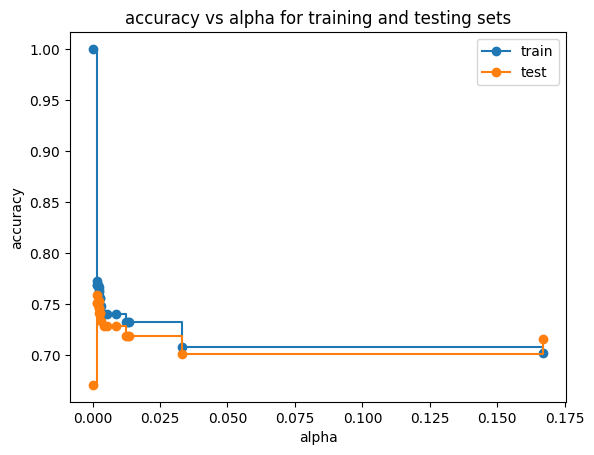

In [11]:
current_best_max_depth=6
current_best_max_leaf_nodes=21

path = dt.cost_complexity_pruning_path(train_features, train_targets)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
current_best_ccp_alpha = 0.0

clfs = [] 
for ccp_alpha in ccp_alphas:
    clf = build_dt(train_features, train_targets, ccp_alpha=ccp_alpha)
    clfs.append(clf)
    score = evaluate_score(dt, test_features, test_targets)
    if score > current_best_score:
        current_best_score = score
        current_best_ccp_alpha = ccp_alphas

dt = build_dt(train_features, train_targets, max_depth=current_best_max_depth, max_leaf_nodes=current_best_max_leaf_nodes, ccp_alpha=current_best_ccp_alpha)
(current_best_precision, current_best_recall, actual_depth, leaf_nodes) = evaluate(dt, test_features, test_targets)
best_score = evaluate_score(dt, test_features, test_targets)
print(f'Post-pruning tree - Decision Tree with {actual_depth=} and {leaf_nodes=} pruned by {current_best_ccp_alpha=} has precision={current_best_precision:f} and recall={current_best_recall:f} and {best_score=:f}')

train_scores = []
test_scores = []
index = 0

for clf in clfs:
    train_scores.append(clf.score(train_features, train_targets))
    test_scores.append(clf.score(test_features, test_targets))
    print(ccp_alphas[index], test_scores[index])
    index+=1

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show() 


## Decision Tree evaluation
The best Decision Tree (DT) seems to classify the 'Graduate' class the best. Unfortunately the label has a lot of false positives so the precision is around 75-80%.
The 'Dropout' category is similarly classified in a similar percentage and the precision is close to the 'Graduate.
The 'Enrolled' category is very problematic. The precision and recall are close to 30% - most students with this label are misclassified. 

One of the reasons for this is probably the fact that this label has the lowest population in the original data.

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

print("\nDecision Tree\n")
test_results = dt.predict(test_features)
print(confusion_matrix(test_targets, test_results), "\n")

print('Overall accuracy:', accuracy_score(test_targets, test_results))
print('F1_score:', f1_score(test_targets, test_results, average='micro'))
print()
print('Dropout precision:', precision_score(test_targets, test_results, average='micro', labels=['Dropout']))
print('Enrolled precision:', precision_score(test_targets, test_results, average='micro', labels=['Enrolled']))
print('Graduate precision:', precision_score(test_targets, test_results, average='micro', labels=['Graduate']))
print()
print('Dropout recall:', recall_score(test_targets, test_results, average='micro', labels=['Dropout']))
print('Enrolled recall:', recall_score(test_targets, test_results, average='micro', labels=['Enrolled']))
print('Graduate recall:', recall_score(test_targets, test_results, average='micro', labels=['Graduate']))



Decision Tree

[[200  36  64]
 [ 25  43  75]
 [  2  11 429]] 

Overall accuracy: 0.7593220338983051
F1_score: 0.7593220338983051

Dropout precision: 0.8810572687224669
Enrolled precision: 0.4777777777777778
Graduate precision: 0.7552816901408451

Dropout recall: 0.6666666666666666
Enrolled recall: 0.3006993006993007
Graduate recall: 0.9705882352941176


## AdaBoost improvement on the best decision tree
As a direct result of the above, I decided to apply the AdaBoost Classifier which helps to force classifiers to work on the exception cases, in this case the 'Enrolled' population. I run GridSearchCV to figure out the best parameters as per below code and the overall results are  better than the plain DT. The overall accuracy improved from 68% to 74%.

The 'Graduate' class is still the best at recall but the precision is in the similar range as the DT - lots of false positives.
The 'Dropout' category recall and precision both improve.
The 'Enrolled' category remains problematic. The precision improves as less false positives from other classes end up here but the bulk of 'Enrolled' still get classified as 'Graduate'

In [13]:
from sklearn.ensemble import AdaBoostClassifier

est_search_range = np.arange(5, 55, step=5)
lr_search_range = np.linspace(0.1, 1, num=10)
parameters = {'n_estimators': est_search_range, 'learning_rate': lr_search_range}
print(parameters)

def createAdaBoost(features, labels, n_estimators=50, learning_rate=1.0):
    return AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate).fit(features, labels.values.ravel())

grid = GridSearchCV(AdaBoostClassifier(estimator=dt), param_grid=parameters, cv=3, verbose=1).fit(train_features, train_targets.values.ravel())
print(grid.best_score_, grid.best_params_)

ada_boost = createAdaBoost(train_features, train_targets, n_estimators=grid.best_params_['n_estimators'], learning_rate=grid.best_params_['learning_rate'])

print("\nAda-Boosted DT\n")
test_results = ada_boost.predict(test_features)
print(confusion_matrix(test_targets, test_results), "\n")

print('Overall accuracy:', accuracy_score(test_targets, test_results))
print('F1_score:', f1_score(test_targets, test_results, average='micro'))
print()
print('Dropout precision:', precision_score(test_targets, test_results, average='micro', labels=['Dropout']))
print('Enrolled precision:', precision_score(test_targets, test_results, average='micro', labels=['Enrolled']))
print('Graduate precision:', precision_score(test_targets, test_results, average='micro', labels=['Graduate']))
print()
print('Dropout recall:', recall_score(test_targets, test_results, average='micro', labels=['Dropout']))
print('Enrolled recall:', recall_score(test_targets, test_results, average='micro', labels=['Enrolled']))
print('Graduate recall:', recall_score(test_targets, test_results, average='micro', labels=['Graduate']))

{'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]), 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
0.7558651159893235 {'learning_rate': 0.2, 'n_estimators': 10}

Ada-Boosted DT

[[229   0  71]
 [ 51   0  92]
 [ 23   0 419]] 

Overall accuracy: 0.7322033898305085
F1_score: 0.7322033898305085

Dropout precision: 0.7557755775577558
Enrolled precision: 0.0
Graduate precision: 0.7199312714776632

Dropout recall: 0.7633333333333333
Enrolled recall: 0.0
Graduate recall: 0.9479638009049773


/mnt/c/Users/socra/Documents/Coursera/Introduction to Machine Learning/final/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Classifier
Next step is to attempt to improve on the single Decision Tree Classifier by using a Random Forest Classifier.
Similarly to Ada-boost above, I tried GridSearchCV to find the best values to use - this took a long time to execute (~1h) so it is commented out below.

The Random Forest Classifier results have an even higher overall accuracy than the previous classifiers (77%) but the same problems remain - 'Enrolled' class is below 50% precision and recall.

In [14]:
from sklearn.ensemble import RandomForestClassifier

# bootstrap is set to false because we have already saved 20% of the dataset for testing so I want the forests to be trained on the entire dataset.
def build_random_forest(features, labels, max_depth=None, max_leaf_nodes=None, ccp_alpha=0.0):
    return RandomForestClassifier(bootstrap=False, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, ccp_alpha=ccp_alpha).fit(features, labels.values.ravel())

rf = build_random_forest(train_features, train_targets)
def_score = evaluate_score(rf, test_features, test_targets)
print(f'Starting point - Random Forest with has {def_score=:f}')

# Running this takes ~60 minutes so I'm just showing the result here.
#search_range = [ i for i in range(2, 51) ]
#parameters = {'max_depth': search_range, 'max_leaf_nodes': search_range}
#grid = GridSearchCV(rf, param_grid=parameters, cv=3, verbose=1).fit(train_features, train_targets.values.ravel())
#print(grid.best_score_, grid.best_params_)
print("0.7668837423268786 {'max_depth': 41, 'max_leaf_nodes': 47}")

rf_grid = build_random_forest(train_features, train_targets, max_depth=41, max_leaf_nodes=47)
def_score = evaluate_score(rf_grid, test_features, test_targets)
print(f'After doing grid search - Random Forest with has {def_score=:f}')

print("\nRandom Forest\n")
test_results = rf.predict(test_features)
print(confusion_matrix(test_targets, test_results), "\n")

print('Overall accuracy:', accuracy_score(test_targets, test_results))
print('F1_score:', f1_score(test_targets, test_results, average='micro'))
print()
print('Dropout precision:', precision_score(test_targets, test_results, average='micro', labels=['Dropout']))
print('Enrolled precision:', precision_score(test_targets, test_results, average='micro', labels=['Enrolled']))
print('Graduate precision:', precision_score(test_targets, test_results, average='micro', labels=['Graduate']))
print()
print('Dropout recall:', recall_score(test_targets, test_results, average='micro', labels=['Dropout']))
print('Enrolled recall:', recall_score(test_targets, test_results, average='micro', labels=['Enrolled']))
print('Graduate recall:', recall_score(test_targets, test_results, average='micro', labels=['Graduate']))



Starting point - Random Forest with has def_score=0.774011
0.7668837423268786 {'max_depth': 41, 'max_leaf_nodes': 47}
After doing grid search - Random Forest with has def_score=0.761582

Random Forest

[[219  39  42]
 [ 27  57  59]
 [ 14  19 409]] 

Overall accuracy: 0.7740112994350282
F1_score: 0.7740112994350282

Dropout precision: 0.8423076923076923
Enrolled precision: 0.4956521739130435
Graduate precision: 0.8019607843137255

Dropout recall: 0.73
Enrolled recall: 0.3986013986013986
Graduate recall: 0.9253393665158371


## Decision Tree Analysis
Using the below code we can visualize the decision tree and view the decision points.
The list of features that are part of the decision rules are:

<li>Curricular units 2nd sem (approved)</li>
<li>Curricular units 2nd sem (grade)</li>
<li>Curricular units 1st sem (approved)</li>
<li>Curricular units 1st sem (enrolled)</li>
<li>Curricular units 1st sem (evaluations)</li>
<li>Tuition fees up to date</li>
<li>Age at enrollment </li>
<li>Course</li>
<li>GDP</li>
<br>
Some of these features are reasonble - the performance on 1st and 2nd semester as well as Tuition fees were called out from the beginning in the correlation matrix so they make sense as final determinants. Age, Course and GDP are the new features that seem to be important.
Age being identified as a negative-correlation - the older you are the less chances to finish demanding course-work due to other obligations.
Course makes sense as well, as there will be different loads and demands on students depending on the actual degree they are pursuing.
GDP is a surprisingly important factor. I would assume the reason it is here is that more people decide to pursue a degree when the overall economy is down and stay to complete it, while in the opposite case with a well-functioning economy and more jobs available, people drop-out to seek employment.

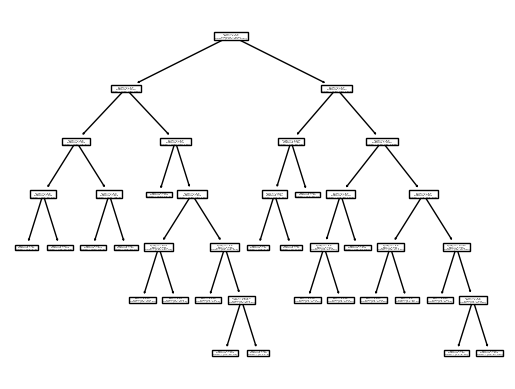

|--- Curricular units 2nd sem (approved) <= 4.50
|   |--- Curricular units 2nd sem (approved) <= 1.50
|   |   |--- Curricular units 1st sem (enrolled) <= 0.50
|   |   |   |--- Tuition fees up to date <= 0.50
|   |   |   |   |--- class: Dropout
|   |   |   |--- Tuition fees up to date >  0.50
|   |   |   |   |--- class: Graduate
|   |   |--- Curricular units 1st sem (enrolled) >  0.50
|   |   |   |--- Curricular units 2nd sem (grade) <= 5.00
|   |   |   |   |--- class: Dropout
|   |   |   |--- Curricular units 2nd sem (grade) >  5.00
|   |   |   |   |--- class: Dropout
|   |--- Curricular units 2nd sem (approved) >  1.50
|   |   |--- Tuition fees up to date <= 0.50
|   |   |   |--- class: Dropout
|   |   |--- Tuition fees up to date >  0.50
|   |   |   |--- Curricular units 2nd sem (approved) <= 3.50
|   |   |   |   |--- Age at enrollment <= 22.50
|   |   |   |   |   |--- class: Enrolled
|   |   |   |   |--- Age at enrollment >  22.50
|   |   |   |   |   |--- class: Dropout
|   |   |   

In [15]:
from sklearn.tree import plot_tree, export_text
exp = export_text(dt, feature_names=feature_dataset.columns)
with open('tree_export', 'w') as f:
    f.write(exp)
    f.close()
    
plot_tree(dt)
plt.savefig('decision_tree.png', bbox_inches='tight', dpi=300)
plt.show()

print(exp)

# Discussions and Conclusion
The project was an interesting 3-category classification problem where there are a lot of features given with categorical values. This prevents a straightforward linear/logistic regression unless we convert every feature into 1/0 Yes/No variable which would significantly increase the number of features.
I chose to use the decision tree classifier as I think it fit the parameters of the problem very well and would have room for improvments via parameter selection and ensemble methods. In the end, the final accuracy of 77% for the RandomForestClassifier seems to be good enough as it is higher than the accuracy in the original paper, although they ignored the features which come from 1st and 2nd semester data as they wanted the prediction to be only on the initial data as the student comes in. As we see above in the decision tree however, these factors are the best determinants of eventual success.